# EDA notebook
Also has data cleaning and feature engineering
- Polar coordinates
- outliers detection and removal
- nan value removal

Extra:
- Explore using histogram plot. 
- Instead of just meaning col, use other columns.

# Import

In [2]:
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


# Specific tf libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

# Helper functions

In [3]:
%run ../common_utils.py
fractionOfData = 1
pd.options.mode.chained_assignment = None  # default='warn'

# Load data

## Metadata

In [3]:
metaData_apartment = pd.read_json('../data/apartments_meta.json')
metaData_building = pd.read_json('../data/buildings_meta.json')

In [4]:
metaData_apartment.at[0, 'name'] = 'apartment_id'
metaData_building.at[0, 'name'] = 'building_id'

In [5]:
metaData = pd.concat([metaData_apartment, metaData_building])
metaData

,name,type,desc,cats
0,apartment_id,integer_id,Unique ID for apartment,NaN
1,seller,categorical,The type of apartment seller,"[Owner, Company, Agents, Developer]"
2,price,real,The listed price of the apartment (TARGET),NaN
3,area_total,real,Total area of the apartment,NaN
4,area_kitchen,real,Total kitchen area in the apartment,NaN
5,area_living,real,Total living space area in the apartment,NaN
6,floor,integer,Primary building floor of the apartment,NaN
7,rooms,integer,Number of rooms in the apartment,NaN
8,layout,categorical,Overal apartment layout,"[Adjacent, Isolated, Adjacent_isolated]"
9,ceiling,real,Ceiling height in the apartment,NaN


In [6]:
pd.set_option('display.max_colwidth', None)
display(metaData.loc[metaData['name'] == "material"]["cats"])
display(metaData.loc[metaData['name'] == "district"]["cats"])
display(metaData.loc[metaData['name'] == "parking"]["cats"])

8    [Bricks, Wood, Monolith, Panel, Block, Monolithic_brick, Stalin_project]
Name: cats, dtype: object

4    [Central, North, North-East, East, South-East, South, South-West, West, North-West, Zelenograd, Troitsk, Novomoskovsk]
Name: cats, dtype: object

13    [Ground, Underground, Multilevel]
Name: cats, dtype: object

## Train data

In [7]:
train_apartment = pd.read_csv('../data/apartments_train.csv')

In [8]:
train_building = pd.read_csv('../data/buildings_train.csv')

In [9]:
train = pd.merge(train_apartment, train_building, left_on='building_id', right_on='id')
#train.rename(columns={'id_x' : 'apartment_id', 'id_y' : 'building_id'}, inplace=True)
train.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
train.drop('id_y', axis=1, inplace=True)
# Remove duplicate column after merge.

In [10]:
# Reduce amount of data for performance reasons during implementation.
train = train.head(int(train.shape[0] * fractionOfData))

## Test data

In [11]:
test_apartment = pd.read_csv('../data/apartments_test.csv')

In [12]:
test_building = pd.read_csv('../data/buildings_test.csv')

In [13]:
test = pd.merge(test_apartment, test_building, left_on='building_id', right_on='id')
test.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
test.drop('id_y', axis=1, inplace=True)

# Outliers

23197
23285


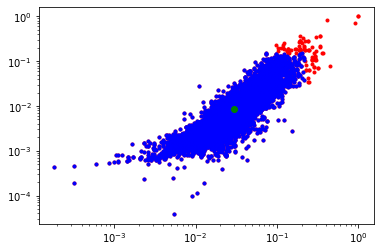

In [14]:
# Remove outlayers
outliers_value = 7
some_features = ["area_total", "area_kitchen", "area_living", "floor", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed", "price"]

normalized_train = train[some_features]
normalized_train = (normalized_train-normalized_train.min())/(normalized_train.max()-normalized_train.min())

# Can remove outlayers based on 
no_outlayers = normalized_train[(np.abs(stats.zscore(normalized_train[["area_total", "price"]])) < outliers_value).all(axis=1)]
print(len(no_outlayers))
print(len(normalized_train))

plt.plot(normalized_train['area_total'], normalized_train['price'], 'r.')
plt.plot(no_outlayers['area_total'], no_outlayers['price'], 'b.')
plt.plot(normalized_train['area_total'].mean(), normalized_train['price'].mean(), 'og')
plt.xscale("log")
plt.yscale("log")
plt.show()

# Polar coordinates

In [96]:
# "All" numerical features
numerical_features = ["area_total", "area_kitchen", "area_living", "floor", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed"]
outliers_value = 7

# Outlayer removal
no_outlayers = train[(np.abs(stats.zscore(train[["area_total", "price"]])) < outliers_value).all(axis=1)] 

# Labels and targets
labels1 = no_outlayers[numerical_features]
labels1 = labels1.fillna(labels1.mean())
targets1= no_outlayers['price'] # Non nan values here.

# Test
test1 = test[numerical_features]
test1 = test1.fillna(test1.mean())

# Normalize
normalized_labels1 = (labels1-labels1.min())/(labels1.max()-labels1.min())
normalized_test1 = (test1-test1.min())/(test1.max()-test1.min())

In [97]:
# Make a copy
labels1_normed_r = normalized_labels1.copy()
test1_normed_r = normalized_test1.copy()

# Move origo to centre
labels1_normed_r['latitude'] = labels1_normed_r['latitude'] -  labels1_normed_r['latitude'].mean()
labels1_normed_r['longitude'] = labels1_normed_r['longitude'] -  labels1_normed_r['longitude'].mean()
test1_normed_r['latitude'] = test1_normed_r['latitude'] -  test1_normed_r['latitude'].mean()
test1_normed_r['longitude'] = test1_normed_r['longitude'] -  test1_normed_r['longitude'].mean()

# Convert to polar coordinates
labels1_normed_r['r'] =  np.sqrt(labels1_normed_r['latitude']**2 + labels1_normed_r['longitude']**2)
labels1_normed_r['theta'] = np.arctan(labels1_normed_r['longitude']/labels1_normed_r['latitude'])
test1_normed_r['r'] =  np.sqrt(test1_normed_r['latitude']**2 + test1_normed_r['longitude']**2)
test1_normed_r['theta'] = np.arctan(test1_normed_r['longitude']/test1_normed_r['latitude'])

[-5.973006572971485e-17, -3.308126717338053e-17]


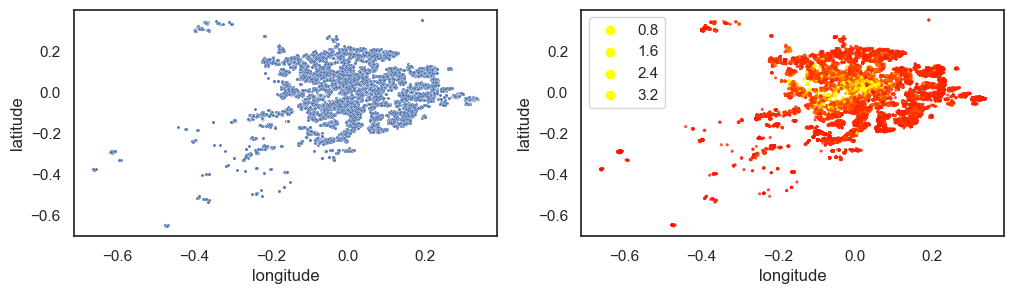

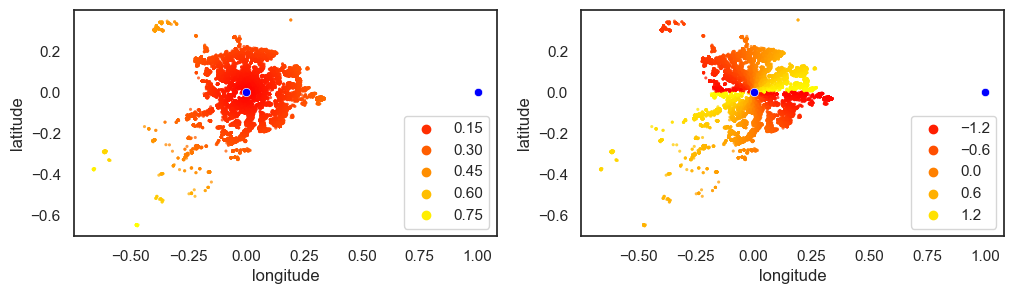

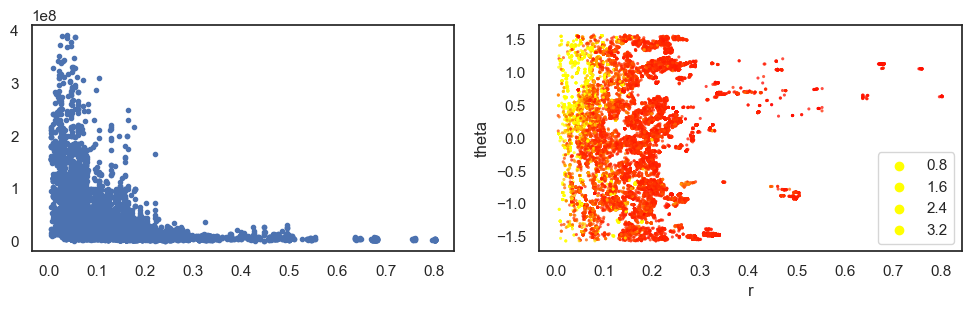

In [106]:
# Cartesian plot
fig, (ax1, ax2) = plt.subplots(figsize=(12, 3), ncols=2, dpi=100)
lo, hi = targets1.quantile([0.0, 0.9])
hue_norm = plt.Normalize(lo, hi)
hue = targets1.tolist()

sns.scatterplot(x='longitude', y='latitude', ax=ax1, alpha=1, s=5, data=labels1_normed_r[['latitude', 'longitude']])
sns.scatterplot(x='longitude', y='latitude', ax=ax2, hue=hue, alpha=0.75, s=5, palette="autumn", linewidth=0, hue_norm=hue_norm, data=labels1_normed_r[['latitude', 'longitude']])

# 
fig, (ax5, ax6) = plt.subplots(figsize=(12, 3), ncols=2, dpi=100)
hue=labels1_normed_r['r'].tolist()
sns.scatterplot(x='longitude', y='latitude', ax=ax5, hue=hue, palette="autumn", alpha=0.75, s=5, linewidth=0, data=labels1_normed_r[['latitude', 'longitude']])
sns.scatterplot(ax=ax5, color="blue", data=[labels1_normed_r['latitude'].mean(), labels1_normed_r['longitude'].mean() ])

hue=labels1_normed_r['theta'].tolist()
sns.scatterplot(x='longitude', y='latitude', ax=ax6, hue=hue, palette="autumn", alpha=0.75, s=5, linewidth=0, data=labels1_normed_r[['latitude', 'longitude']])
sns.scatterplot(ax=ax6, color="blue", data=[labels1_normed_r['latitude'].mean(), labels1_normed_r['longitude'].mean() ])
print([labels1_normed_r['latitude'].mean(), labels1_normed_r['longitude'].mean()])

## Polar plot
hue = targets1.tolist()
fig, (ax3, ax4) = plt.subplots(figsize=(12, 3), ncols=2, dpi=100)
#sns.scatterplot(x='r', y='theta', ax=ax3, alpha=1, s=5, data=labels1_normed_r[['r', 'theta']])
sns.scatterplot(x='r', y='theta', ax=ax4, hue=hue, alpha=0.75, s=5, palette="autumn", linewidth=0, hue_norm=hue_norm, data=labels1_normed_r[['r', 'theta']])

ax3.plot(labels1_normed_r['r'], targets1, ".")
plt.show()

## Correlations, drop and nan

Left plot is removing nan values, right uses mean()


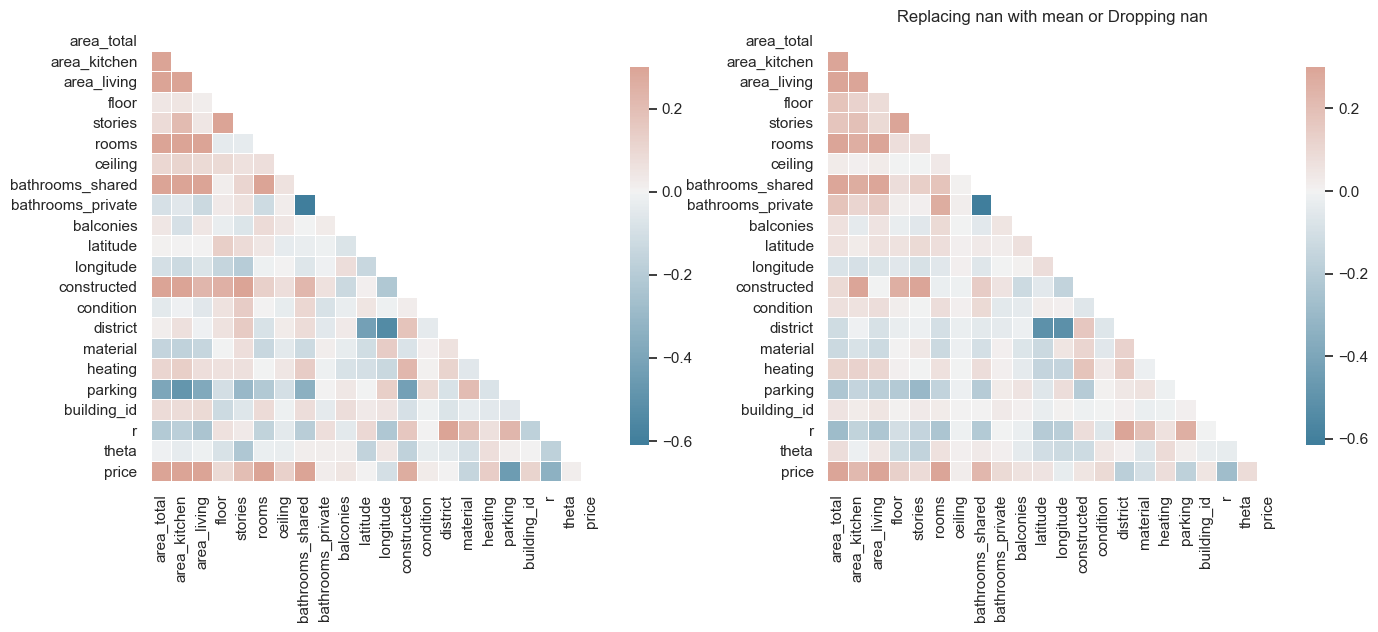

In [271]:
corr_dataframe = pd.merge(labels_n_r, targets, left_index=True, right_index=True)
corr_dataframe2 = pd.merge(labels2_n_r, targets2, left_index=True, right_index=True)
# Compute the correlation matrix
corr = corr_dataframe.corr()
corr2 = corr_dataframe2.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
mask2 = np.triu(np.ones_like(corr2, dtype=bool))
# Set up the matplotlib figure
f, (ax1, ax2) = plt.subplots(figsize=(16, 10), ncols=2, dpi=100)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="white")
sns.heatmap(corr, ax=ax1, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Replacing nan with mean or Dropping nan')
sns.heatmap(corr2, ax=ax2, mask=mask2, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

print("Left plot is removing nan values, right uses mean()")

### What features correlates with price?
Positive correlations:
- Area total, then area living then area kitchen.
- Rooms
- Shared bathrooms
- Constructed
- Stories
- Floor

Negative correlations:
- District
- Material
- Parking
- R

In [273]:
# Extract, normalize, remove outliers
features = ["area_total", "area_kitchen", "area_living", "floor", "stories", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed", # Numerical
           "condition", "district", "material", "heating", "parking", "building_id"]

# Extract labels, targets and preprocess
labels_n, test_n, targets = preProcess_numericalData(features, train, test, outliers_value=100)
labels_n_r, test_n_r = polar_coordinates(labels_n, test_n)

# Drop useless cols
labels_n_r = labels_n_r.drop(['latitude', 'longitude', 'theta'], 1)
test_n_r = test_n_r.drop(['latitude', 'longitude', 'theta'], 1)

<AxesSubplot:>

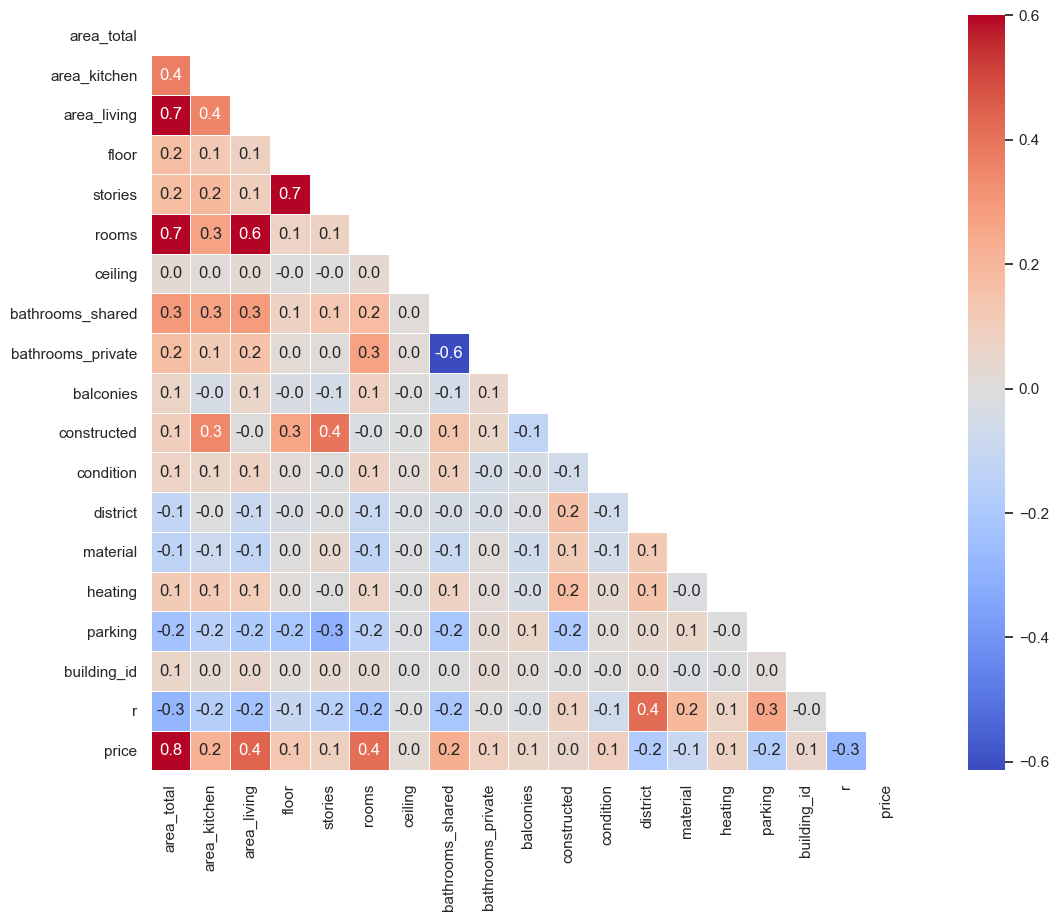

In [274]:
df_all = pd.merge(labels_n_r, targets, left_index=True, right_index=True)
# Compute the correlation matrix
corr = df_all.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(16, 10), dpi=100)
# Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="dark")
sns.heatmap(corr, mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax1)

# Floor/stories
Neither floors nor stories are very correlated to price. What about a floor/stories value?


Explaination of the new features:
- Penthouse: it is the top floor (if floor == stories)
- rel_height: the float value of floor/stories - so a float between 0-1, which is 1 for penthouses
- high-up: upper half of a building, which is above ten stories.
- real_penhouse: is a pentouse of a building with 10 or more stories.

Then the _e tag at the end means that there is also elevator access in the building for passengers.
And the _e_w tag means there are some apartments in the building without elevator for passengers

In [260]:
# Make a copy
# "All" numerical features
features = ["floor", "stories", "elevator_without", "elevator_passenger", "elevator_service"]
outliers_value = 100


# Outlayer and NAN removal!
no_outlayers = train[(np.abs(stats.zscore(train[["area_total", "price"]])) < outliers_value).all(axis=1)] 

# Labels and targets
labels1 = no_outlayers[features]
#labels1[["elevator_without", "elevator_passenger", "elevator_service"]] = labels1[["elevator_without", "elevator_passenger", "elevator_service"]].fillna(0)
labels1.fillna(value=labels1.mean(), inplace=True)
targets = no_outlayers['price'] # Non nan values here.

# New col - rel_height
labels1['rel_height'] = labels1["floor"] / labels1["stories"]
labels1['penthouse'] = labels1["floor"]==labels1["stories"]
labels1['high_up'] = (labels1['rel_height']>0.5) & (labels1['stories']>10)
labels1['real_penthouse'] = (labels1['stories']>10) & (labels1['penthouse'])

# Elevator
labels1['penthouse_e'] = (labels1['penthouse']) & (labels1['elevator_passenger'])
labels1['high_up_e'] = (labels1['high_up']) & (labels1['elevator_passenger'])
labels1['real_penthouse_e'] = (labels1['real_penthouse']) & (labels1['elevator_passenger'])

# Lacks elevator
labels1['penthouse_e_w'] = (labels1['penthouse']) & (labels1['elevator_without'])
labels1['high_up_e_w'] = (labels1['high_up']) & (labels1['elevator_without'])
labels1['real_penthouse_e_w'] = (labels1['real_penthouse']) & (labels1['elevator_without'])



In [261]:
labels1['elevator_without'].value_counts()

0.00000    13926
1.00000     9002
0.39262      357
Name: elevator_without, dtype: int64

In [262]:
labels1['penthouse'].value_counts()

False    21593
True      1692
Name: penthouse, dtype: int64

In [266]:
df_all = pd.merge(targets, labels1, left_index=True, right_index=True)
print(df_all.groupby("penthouse")["price"].mean())
print(df_all.groupby("penthouse_e")["price"].mean())
print(df_all.groupby("penthouse_e_w")["price"].mean())
print(df_all.groupby("high_up")["price"].mean())
print(df_all.groupby("high_up_e")["price"].mean())
print(df_all.groupby("high_up_e_w")["price"].mean())
print(df_all.groupby("real_penthouse")["price"].mean())
print(df_all.groupby("real_penthouse_e")["price"].mean())
print(df_all.groupby("real_penthouse_e_w")["price"].mean())

penthouse
False    2.286944e+07
True     3.232020e+07
Name: price, dtype: float64
penthouse_e
False    2.277103e+07
True     3.617431e+07
Name: price, dtype: float64
penthouse_e_w
False    2.276663e+07
True     4.664275e+07
Name: price, dtype: float64
high_up
False    2.303227e+07
True     2.459225e+07
Name: price, dtype: float64
high_up_e
False    2.307272e+07
True     2.452676e+07
Name: price, dtype: float64
high_up_e_w
False    2.149911e+07
True     3.784124e+07
Name: price, dtype: float64
real_penthouse
False    2.324842e+07
True     3.235400e+07
Name: price, dtype: float64
real_penthouse_e
False    2.324515e+07
True     3.261414e+07
Name: price, dtype: float64
real_penthouse_e_w
False    2.305061e+07
True     7.357480e+07
Name: price, dtype: float64


<AxesSubplot:>

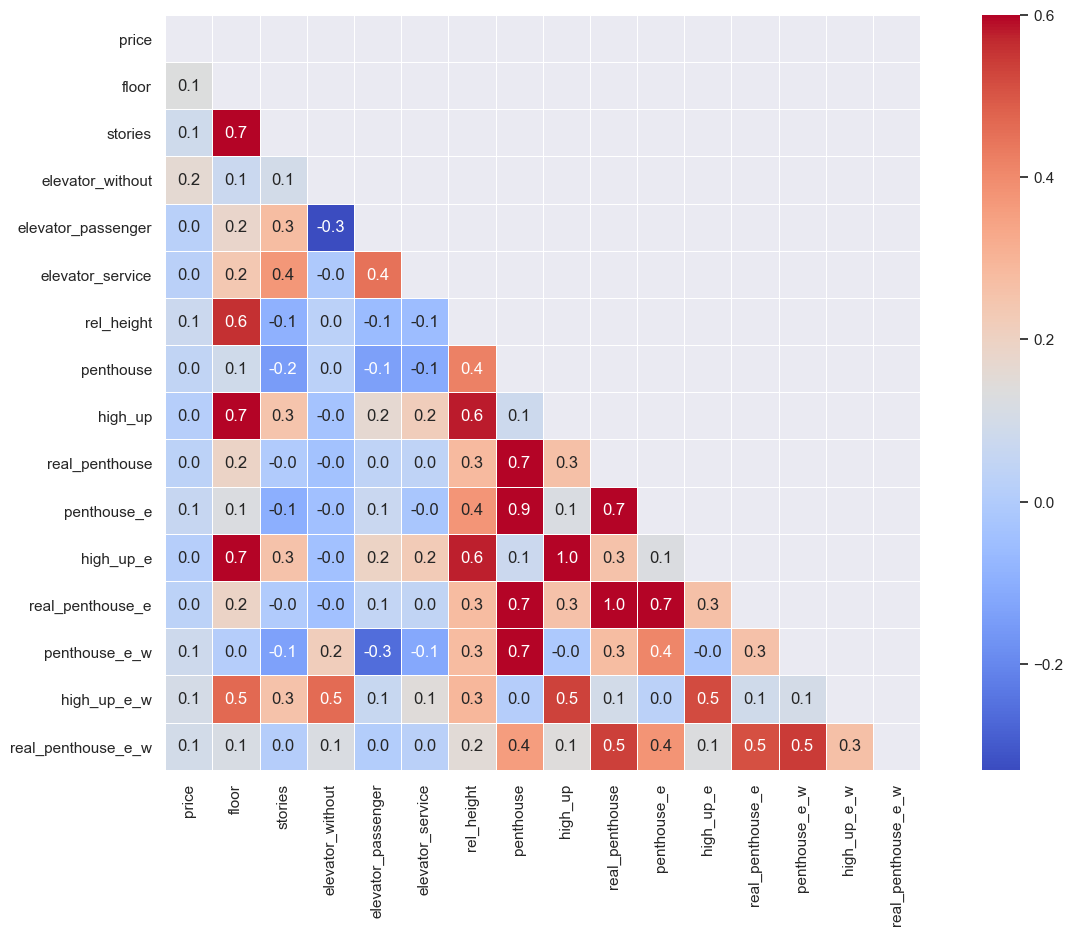

In [269]:
# Compute the correlation matrix
corr = df_all.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(16, 10), dpi=100)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="dark")
sns.heatmap(corr, mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax1)

### WHY DO PEOPLE NOT LIKE ELEVATORS??

## Booleans

<AxesSubplot:>

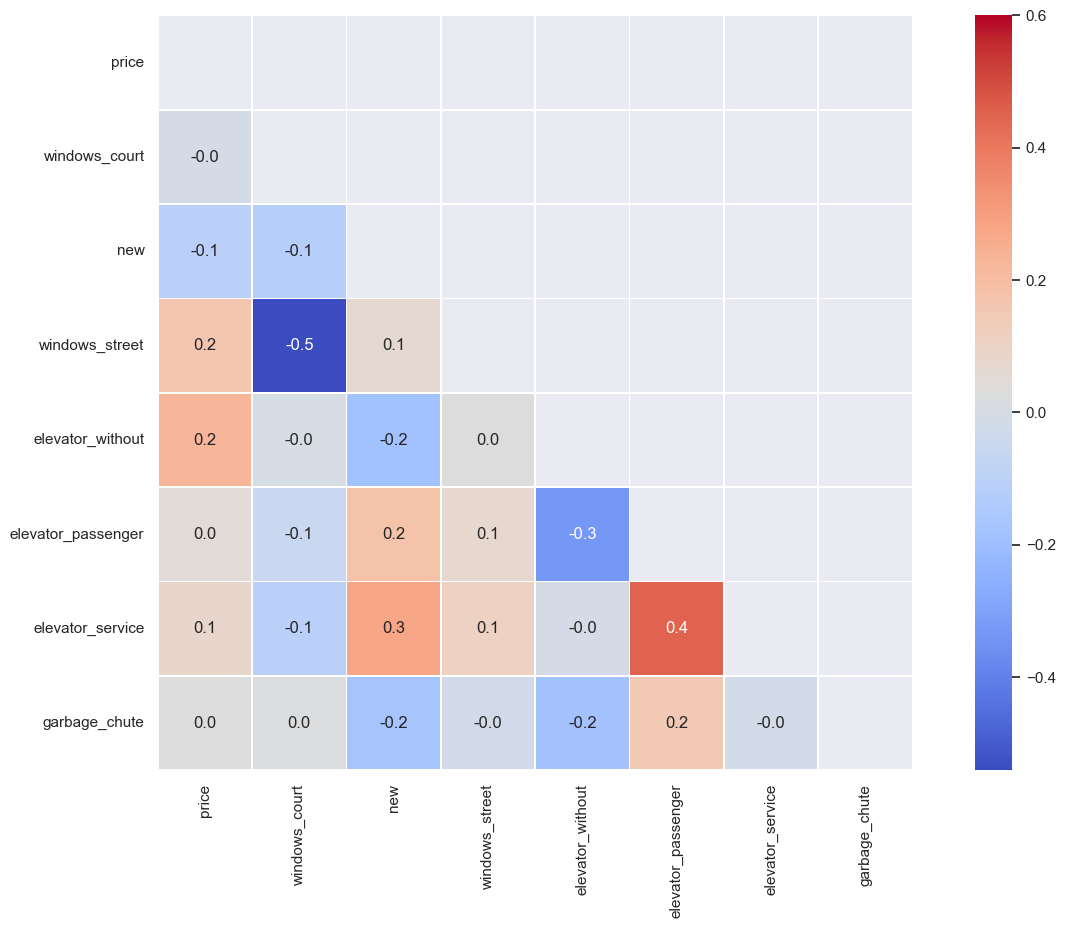

In [19]:
# Make a copy
# "All" numerical features
features = ["windows_court","new", "windows_street", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"]
outliers_value = 4

no_outlayers = train[(np.abs(stats.zscore(train[["area_total", "price"]])) < outliers_value).all(axis=1)] 

# Labels and targets
labels1 = no_outlayers[features]
#labels1[["elevator_without", "elevator_passenger", "elevator_service"]] = labels1[["elevator_without", "elevator_passenger", "elevator_service"]].fillna(0)
labels1.fillna(value=labels1.mean(), inplace=True)
targets = no_outlayers['price'] # Non nan values here.

df_all = pd.merge(targets, labels1, left_index=True, right_index=True)
# Compute the correlation matrix
corr = df_all.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(16, 10), dpi=100)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="dark")
sns.heatmap(corr, mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax1)

### Spaciousness

<AxesSubplot:>

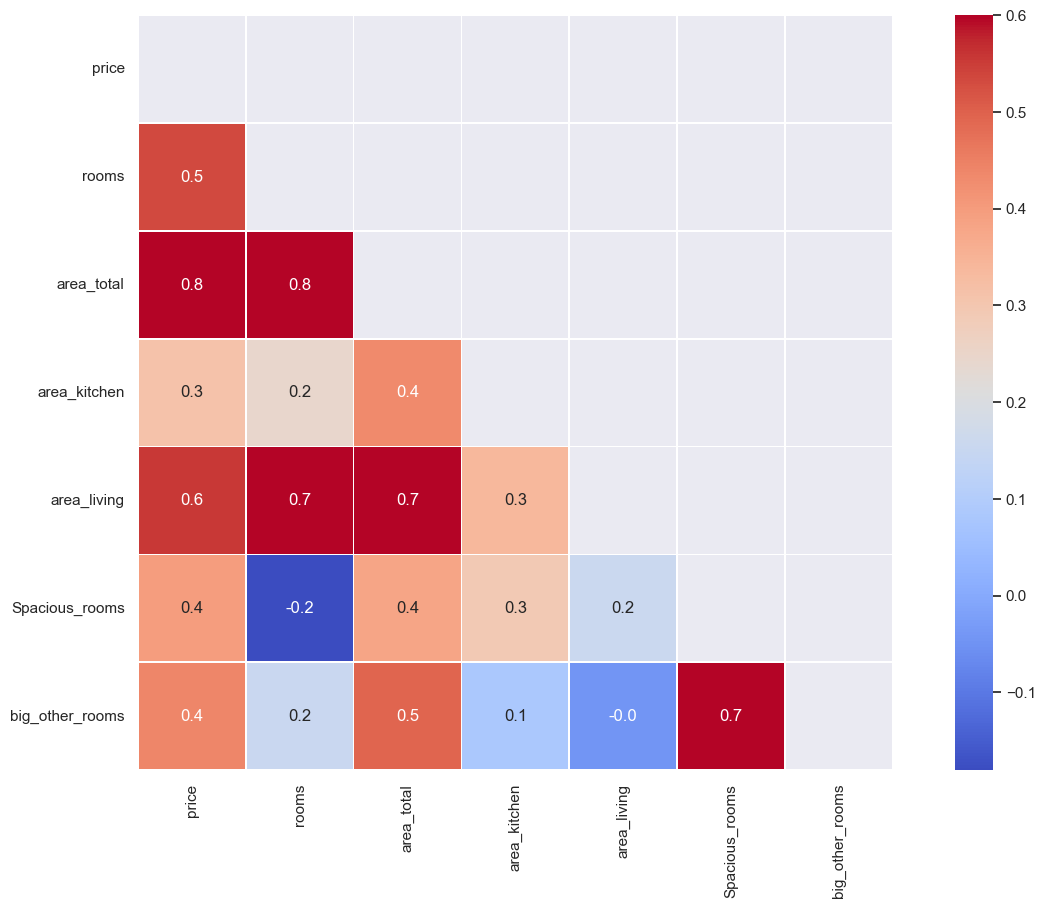

In [22]:
# Make a copy
# "All" numerical features
features = ["rooms", "area_total", "area_kitchen", "area_living"]
outliers_value = 4

no_outlayers = train[(np.abs(stats.zscore(train[["price", "area_total"]])) < outliers_value).all(axis=1)] 

# Labels and targets
labels1 = no_outlayers[features]
#labels1[["elevator_without", "elevator_passenger", "elevator_service"]] = labels1[["elevator_without", "elevator_passenger", "elevator_service"]].fillna(0)
labels1.fillna(value=labels1.mean(), inplace=True)
targets = no_outlayers['price'] # Non nan values here.

#
labels1['Spacious_rooms'] = labels1['area_total'] /labels1['rooms']
#labels1['big_kitchen'] = labels1['area_kitchen'] /labels1['area_total']
#labels1['big_living_room'] = labels1['area_living'] /labels1['area_total']
labels1['big_other_rooms'] = (labels1['area_total']-labels1['area_kitchen']-labels1['area_living']) / labels1['rooms']


df_all = pd.merge(targets, labels1, left_index=True, right_index=True)
# Compute the correlation matrix
corr = df_all.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(16, 10), dpi=100)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="dark")
sns.heatmap(corr, mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax1)

### One hot encoding!

In [39]:
%run ../common_utils.py

In [43]:
features =           ["area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] #String
features = ["layout", "condition", "district", "material", "parking", "heating", "seller"]

numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"]

droptable = []

In [44]:
train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="none",
                    add_R=False, add_rel_height=False, droptable=droptable,
                    one_hot_encode=True, cat_features=cat_features, drop_old=True)

#train_labels, train_targets, val_labels, val_targets, test_labels =

<AxesSubplot:>

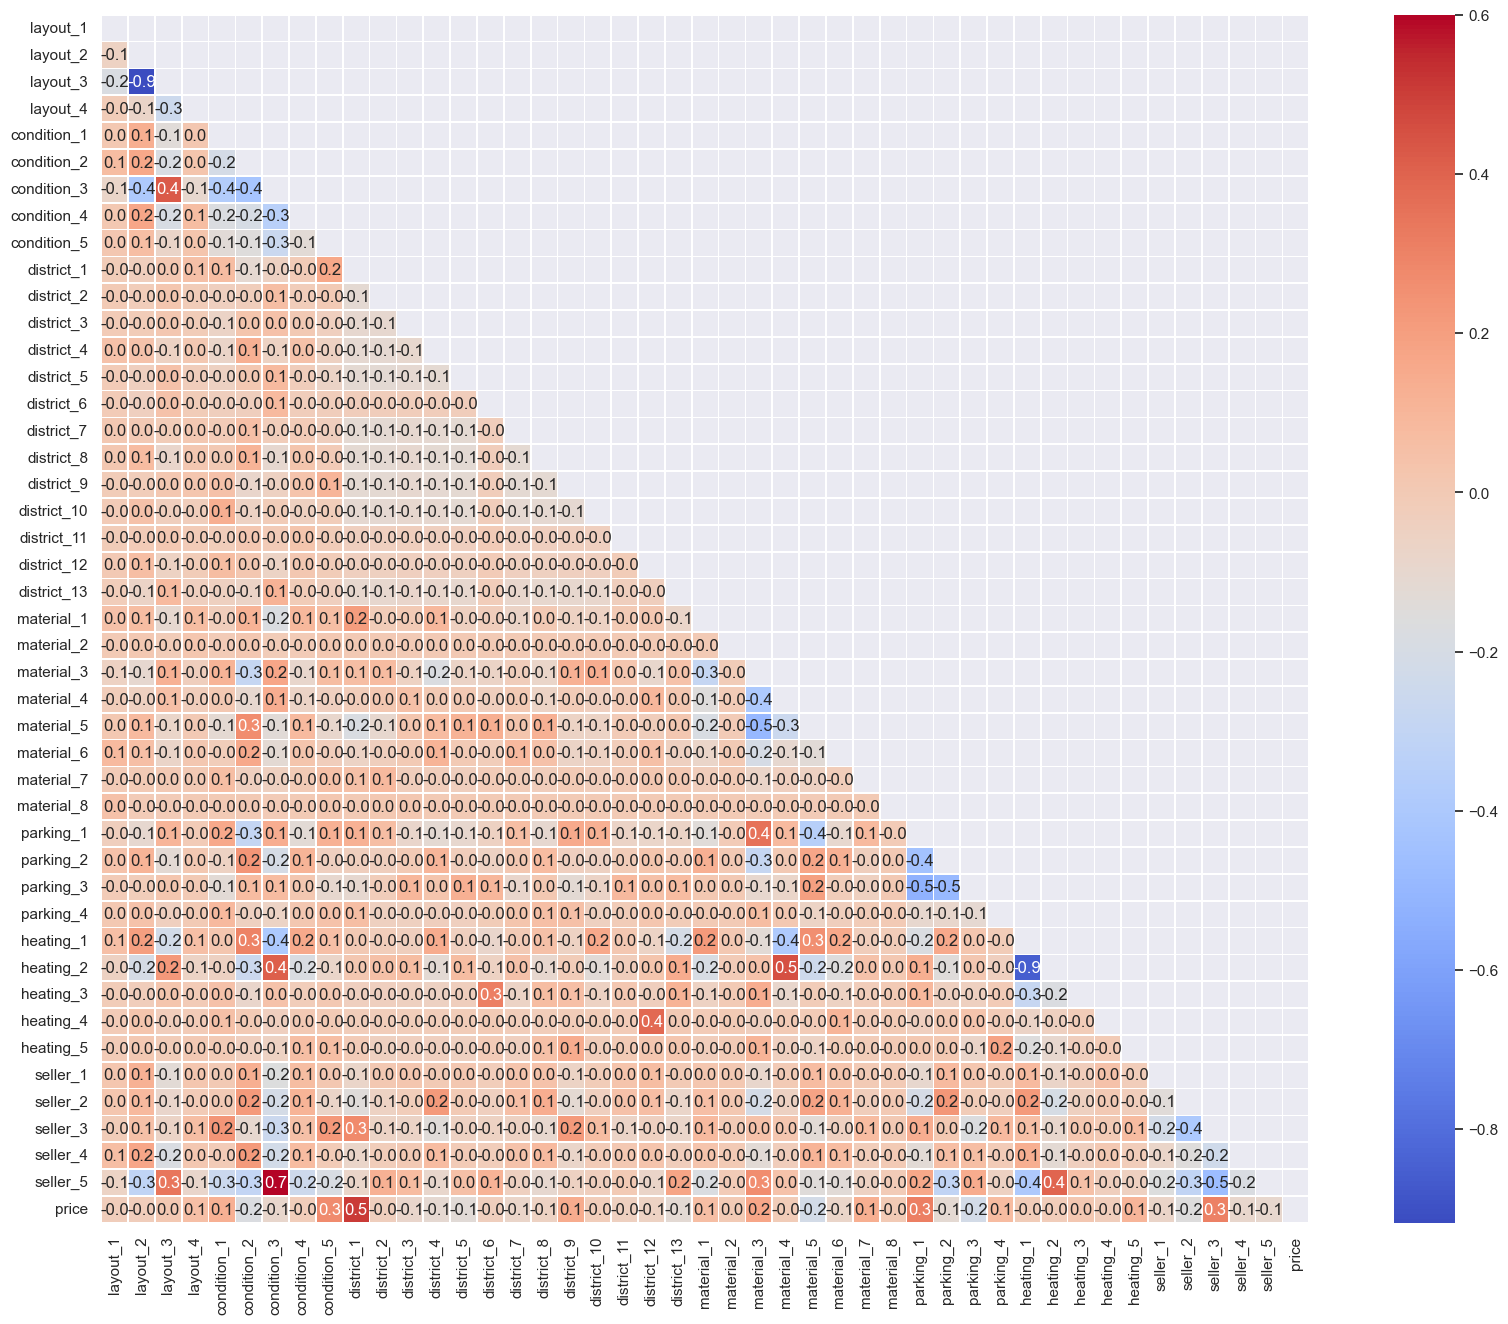

In [45]:
df_all = pd.merge(train_labels, train_targets, left_index=True, right_index=True)
# Compute the correlation matrix
corr = df_all.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(22, 16), dpi=100)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="dark")
sns.heatmap(corr, mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax1)

In [47]:
import xgboost

In [48]:
# PRoblem this only show linear correlation. Lets look for non-linear ones!
model = xgboost.XGBRegressor()
model.fit(train_labels,train_targets)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

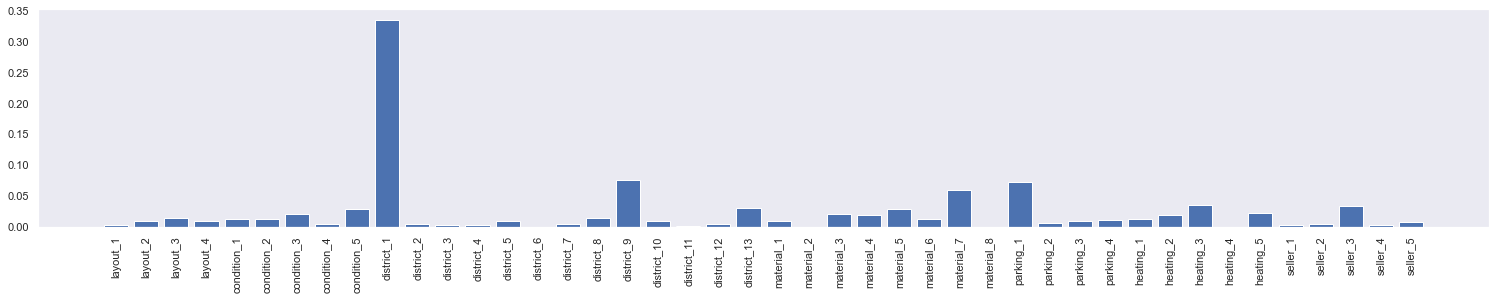

In [50]:
plt.figure(figsize=(26, 4))
plt.bar(train_labels.columns.tolist(), model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

# The NAN values- use other cols to insert nans!

In [4]:
train, test, metaData = load_all_data()

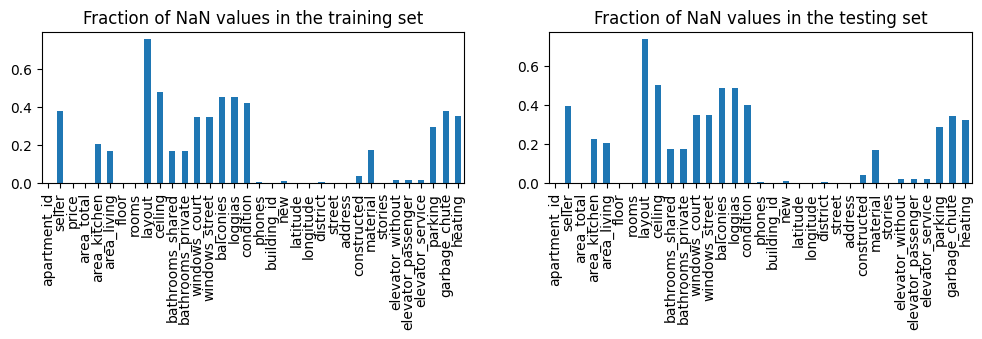

In [40]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 2), ncols=2, dpi=100)
train.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set');

#### LOOKING for correlated features to help fill nan

<AxesSubplot:>

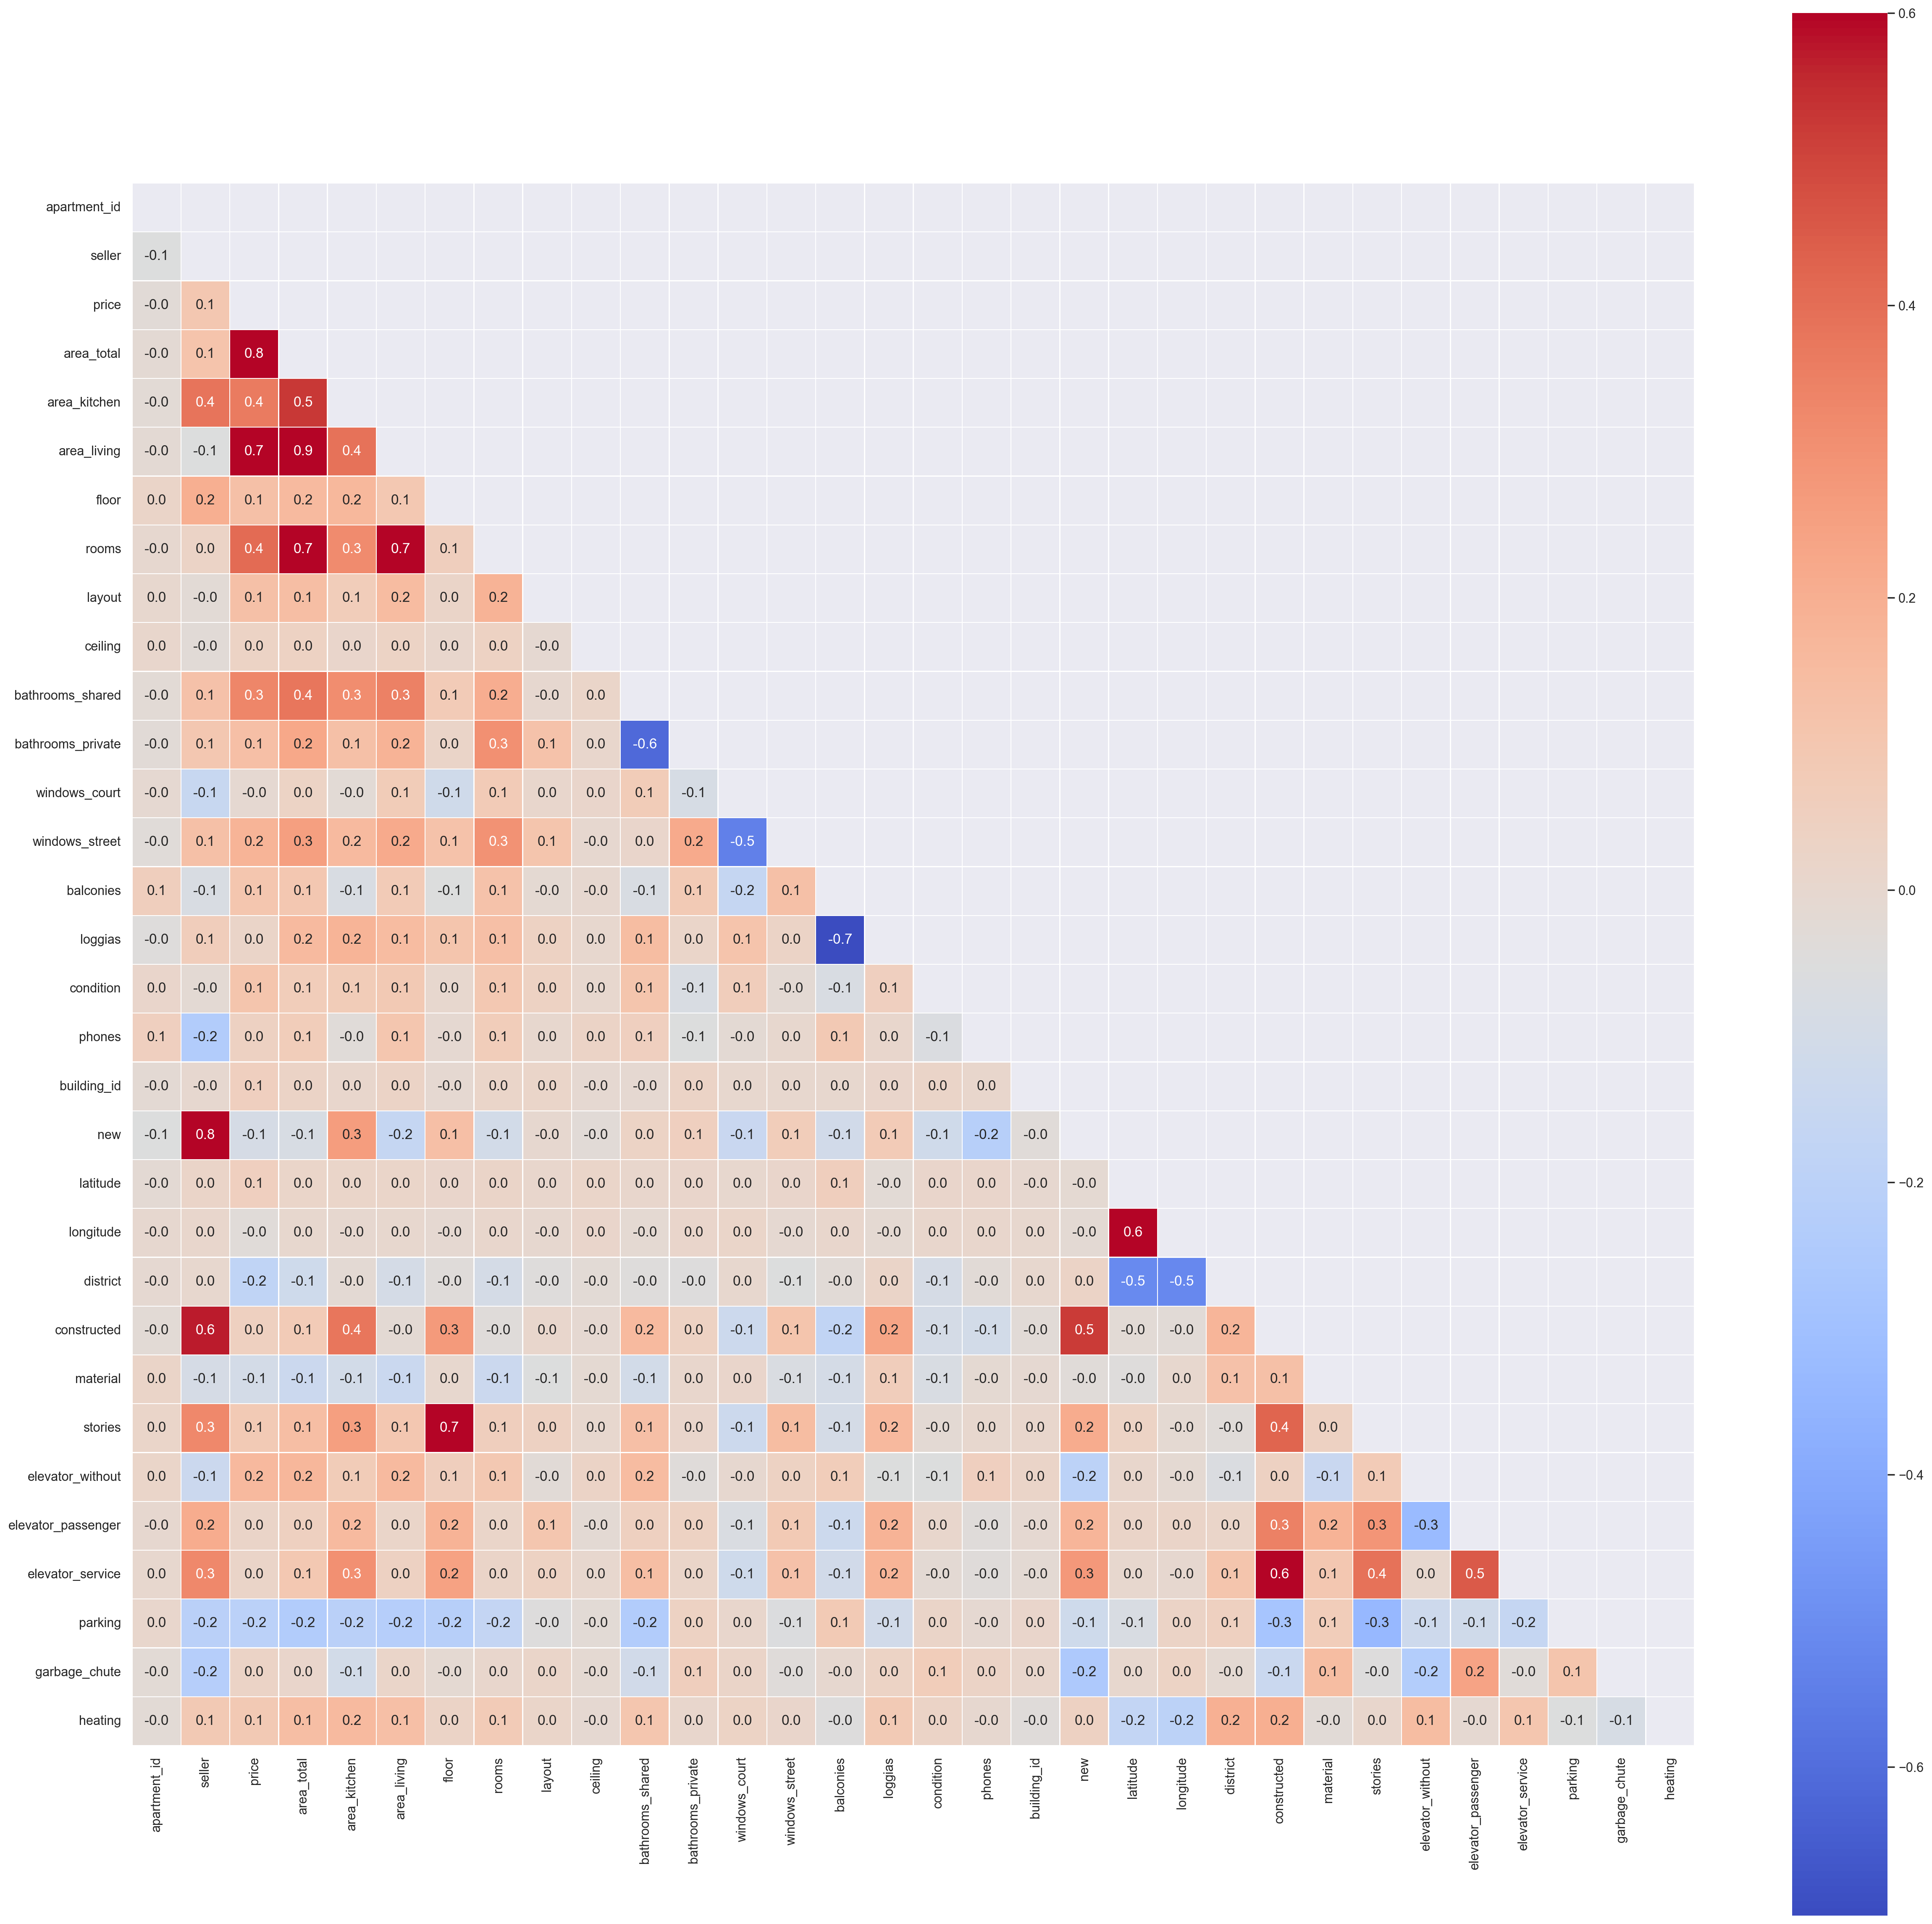

In [47]:
df_all = pd.concat([train, test])
# Compute the correlation matrix
corr = df_all.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(30, 30), dpi=200)
# Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="dark")
sns.heatmap(corr, mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax1)

## Using state of the art fillna techniques we can look for
The most nanned values, do they lose all correlation? If so a better method must be found

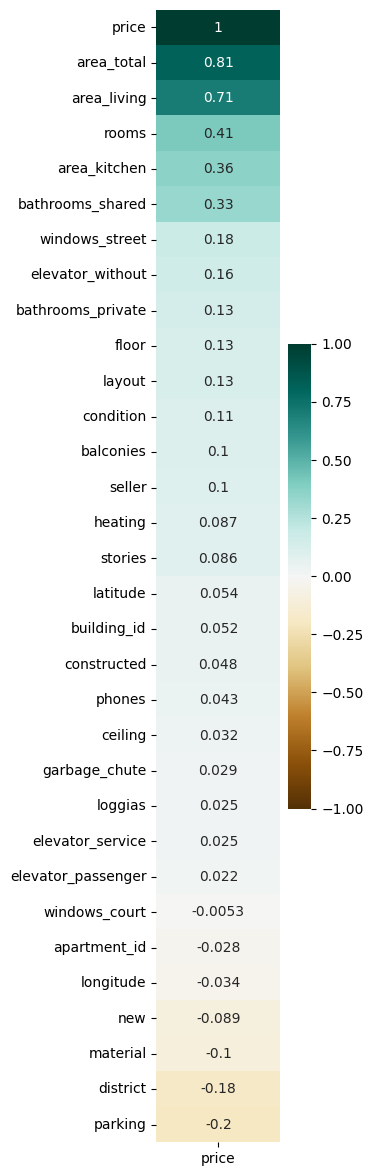

In [5]:
f, ax = plt.subplots(figsize=(2, 15), dpi=100)
heatmap = sns.heatmap(train.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)

In [5]:
# ALL, and building ID!
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms",
                      "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] # Strings

all_numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

float_numerical_features = ["area_total", "area_kitchen", "area_living", "ceiling", "latitude", "longitude", "constructed"]
int_numerical_features = ["floor", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies", "loggias", "phones"] # Ordinal categories

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"] # All are non-ordinal

droptable = []

### 0. APPROACH fill with mean or fill with median

In [4]:
train, test, metaData = load_all_data()
train_labels = train[features].fillna(train[features].median())
train_targets = train["price"]

NameError: name 'features' is not defined

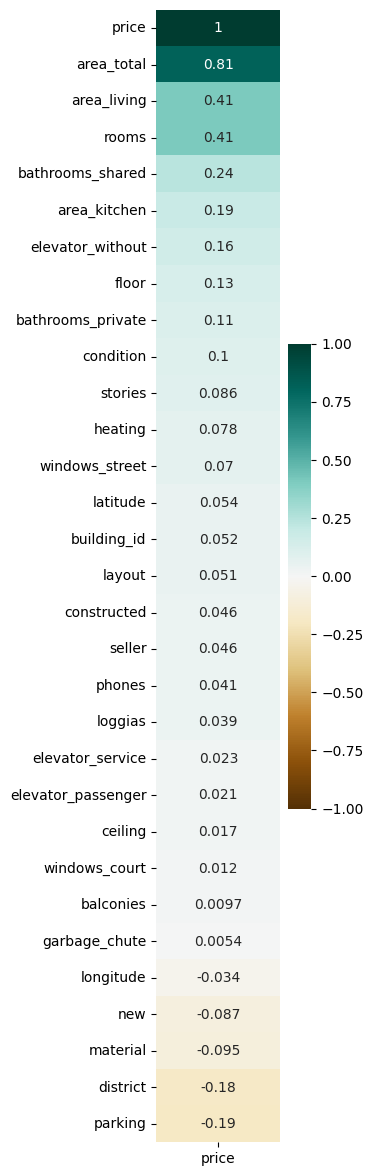

In [33]:
merged = pd.merge(train_labels, train_targets, left_index=True, right_index=True)
f, ax = plt.subplots(figsize=(2, 15), dpi=100)
heatmap = sns.heatmap(merged.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)
plt.savefig('test_approach_2.png')
plt.show()

### 1. APPROACH
Filling nan with mode for cat and bool data. 
NB! They could have "tricked us", making somehow the "best" feature the most normal one randomly or something, who knows.

In [34]:
train, test, metaData = load_all_data()

In [35]:
# Train data preprocessing
train_labels = train[features]
train_targets = train['price']

# Float
train_labels[float_numerical_features] = train_labels[float_numerical_features].fillna(train_labels[float_numerical_features].mean())
# Int
train_labels[int_numerical_features] = train_labels[int_numerical_features].fillna(train_labels[int_numerical_features].median())
# Cat
train_labels[cat_features] = train_labels[cat_features].fillna(train_labels[cat_features].median())
# Bool (The rest)
train_labels = train_labels.fillna(train_labels.median()) # Boolean

# Test data preprocessing
test_labels = test[features]
# Float
test_labels[float_numerical_features] = test_labels[float_numerical_features].fillna(test_labels[float_numerical_features].mean())
# Int
test_labels[int_numerical_features] = test_labels[int_numerical_features].fillna(test_labels[int_numerical_features].median())
# Cat
test_labels[cat_features] = test_labels[cat_features].fillna(test_labels[cat_features].median())
# Bool (The rest)
test_labels = test_labels.fillna(test_labels.median()) # Boolean


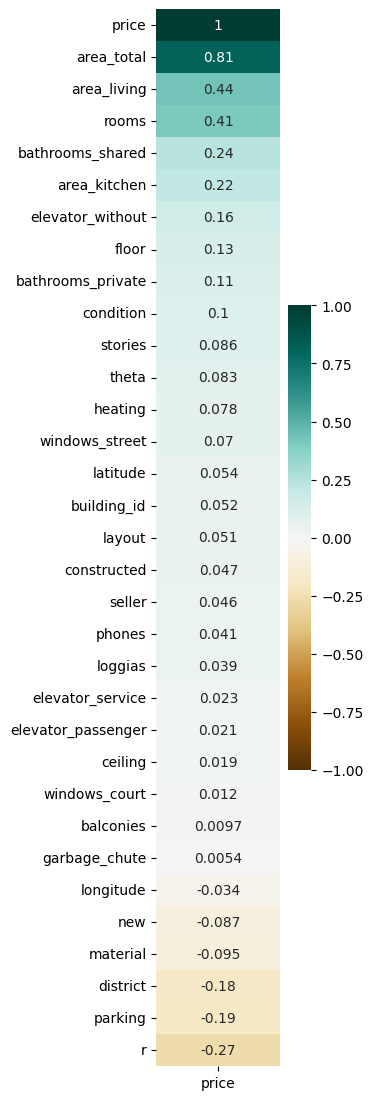

In [39]:
merged = pd.merge(train_labels, train_targets, left_index=True, right_index=True)
f, ax = plt.subplots(figsize=(2, 14), dpi=100)
heatmap = sns.heatmap(merged.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)
plt.savefig('test_approach_2.png')
plt.show()

### 2. APPROACH
Calculate mean across both datasets, instead of one at the time

In [25]:
train, test, metaData = load_all_data()

In [26]:
# TRAIN & TEST
train_labels = train[features]
test_labels = test[features]
train_targets = train['price']

# FLOAT
train_float_mean = train_labels[float_numerical_features].mean()
test_float_mean = test_labels[float_numerical_features].mean()
tl = len(train_labels) + len(test_labels)
total_mean = (train_float_mean*len(train_labels) + test_float_mean*len(test_labels)) / tl

# Median - just use the train, as it is most numerous
# Int
int_median = train_labels[int_numerical_features].median()
# Cat
cat_median = train_labels[cat_features].median()
# Bool (The rest)
bool_median = train_labels.median()

In [27]:
# Train
# Float
train_labels[float_numerical_features] = train_labels[float_numerical_features].fillna(total_mean)
# Int
train_labels[int_numerical_features] = train_labels[int_numerical_features].fillna(int_median)
# Cat
train_labels[cat_features] = train_labels[cat_features].fillna(cat_median)
# Bool (The rest)
train_labels = train_labels.fillna(bool_median) 

# TEST
# Float
test_labels[float_numerical_features] = test_labels[float_numerical_features].fillna(total_mean)
# Int
test_labels[int_numerical_features] = test_labels[int_numerical_features].fillna(int_median)
# Cat
test_labels[cat_features] = test_labels[cat_features].fillna(cat_median)
# Bool (The rest)
test_labels = test_labels.fillna(bool_median) 

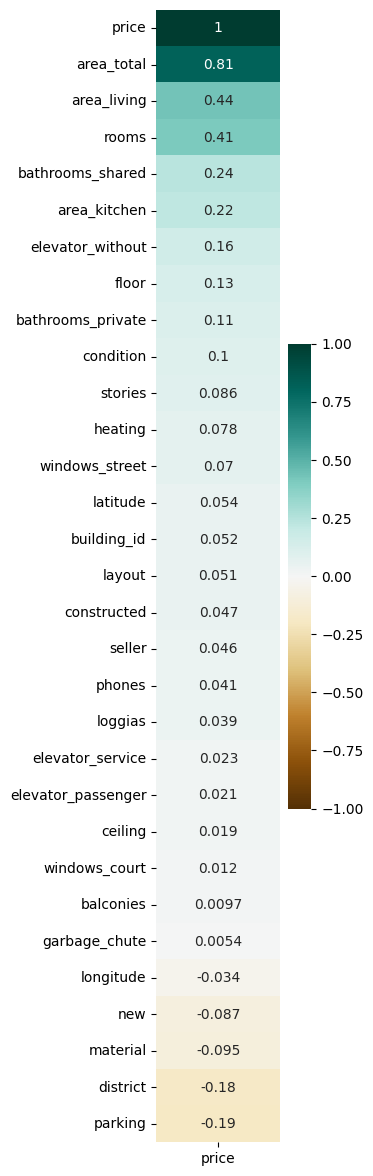

In [28]:
merged = pd.merge(train_labels, train_targets, left_index=True, right_index=True)
f, ax = plt.subplots(figsize=(2, 15), dpi=100)
heatmap = sns.heatmap(merged.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)
plt.savefig('test_approach_2.png')
plt.show()

### 3. APPROACH
Also Use other columns that are well correlated.

In [339]:
train, test, metaData = load_all_data()

In [342]:
test[test["stories"]==test["stories"].max()] # HAS to be in the federation tower!

,apartment_id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
9112,29951,NaN,71.0,NaN,NaN,13.0,1.0,NaN,NaN,2.0,...,22,2019.0,NaN,87.0,0.0,1.0,1.0,2.0,1.0,NaN
9113,29955,NaN,78.0,NaN,NaN,69.0,1.0,NaN,3.8,1.0,...,22,2019.0,NaN,87.0,0.0,1.0,1.0,2.0,1.0,NaN
9114,30355,NaN,95.0,NaN,NaN,11.0,2.0,1.0,3.5,2.0,...,22,2019.0,NaN,87.0,0.0,1.0,1.0,2.0,1.0,NaN
9115,30682,NaN,62.0,NaN,NaN,19.0,2.0,NaN,NaN,1.0,...,22,2019.0,NaN,87.0,0.0,1.0,1.0,2.0,1.0,NaN
9116,31266,NaN,69.0,10.0,42.0,28.0,2.0,1.0,NaN,1.0,...,22,2019.0,NaN,87.0,0.0,1.0,1.0,2.0,1.0,NaN
9117,31971,NaN,96.0,15.0,55.0,10.0,3.0,NaN,NaN,2.0,...,22,2019.0,NaN,87.0,0.0,1.0,1.0,2.0,1.0,NaN
9118,32838,NaN,81.5,15.0,50.0,59.0,3.0,1.0,NaN,NaN,...,22,2019.0,NaN,87.0,0.0,1.0,1.0,2.0,1.0,NaN


We want to log some of the features first! It is found that area_living has a lot of zero values.
Should change these! 

In [72]:
#fs = ["area_total", "area_living", "area_kitchen"]
#for feature in fs:
#    # In case any features has 0, or negative numbers in them
#    remove_zero = [row[feature] if row[feature] >= 1 else train[feature].mean() for _, row in train.iterrows()] 
#    train[feature] = remove_zero
#    
#    remove_zero = [row[feature] if row[feature] >= 1 else test[feature].mean() for _, row in test.iterrows()] 
#    test[feature] = remove_zero
#    
#    # Logging
#    train[feature] = np.log(train[feature])
#    test[feature] = np.log(test[feature])

In [73]:
train["price"] = np.log(train["price"])

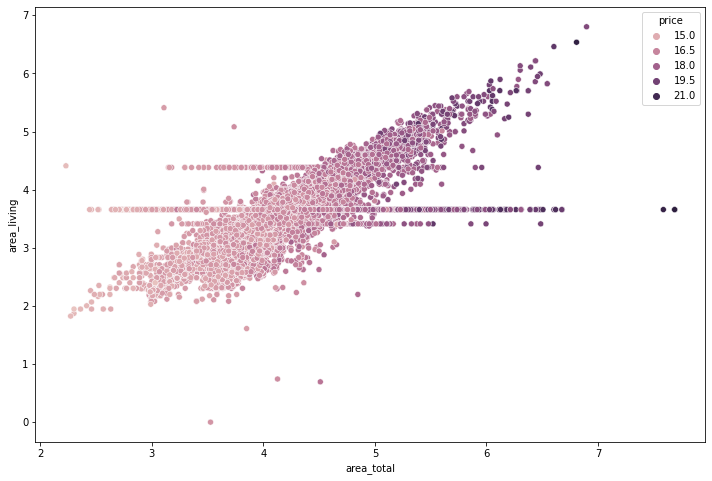

In [74]:
hue=train["price"]
plt.figure(figsize=(12, 8))
sns.scatterplot(data=train, x="area_total", y="area_living", hue=hue)
plt.show()

In [6]:
train, test, metaData = load_all_data()
train_labels = train[features]
test_labels = test[features]
train_targets = train['price']

##### Areas are correlated

In [7]:
train_labels["area_living"].mean() / train_labels["area_total"].mean()

0.5203606013909889

In [8]:
# Zero living area might be correct. See what is best
#(train_labels["area_living"] == 0).sum()
# Replace zero values based on area total - ration.
remove_zero = [row["area_living"] if row["area_living"] >= 1 else row["area_total"]*(train_labels["area_living"].mean() / train_labels["area_total"].mean()) for _, row in train_labels.iterrows()] 
train_labels["area_living"] = remove_zero

remove_zero = [row["area_living"] if row["area_living"] >= 1 else row["area_total"]*(test_labels["area_living"].mean() / test_labels["area_total"].mean()) for _, row in test_labels.iterrows()] 
test_labels["area_living"] = remove_zero

In [9]:
train_labels = fillnaReg(train_labels, ['area_total'], 'area_living')
test_labels = fillnaReg(test_labels, ['area_total'], 'area_living')
# Area_kitchen
train_labels = fillnaReg(train_labels, ['area_total', 'area_living'], 'area_kitchen')
test_labels = fillnaReg(test_labels, ['area_total', 'area_living'], 'area_kitchen')
# ceiling
train_labels = fillnaReg(train_labels, ['stories'], 'ceiling')
test_labels = fillnaReg(test_labels, ['stories'], 'ceiling')

##### There are two nans in long/lat for test data.

In [10]:
display(test_labels[["district", "latitude", "longitude"]][test_labels["latitude"].isna()==True])

,district,latitude,longitude
220,NaN,NaN,NaN
221,NaN,NaN,NaN


Not much to do than use mean. They have no district info either.

In [11]:
unknown_index = test_labels[["district", "latitude", "longitude"]][test_labels["latitude"].isna()==True].index
test_labels.loc[unknown_index,['district']] = test_labels["district"].median()

In [12]:
display(test_labels[["district", "latitude", "longitude"]][test_labels["latitude"].isna()==True])

,district,latitude,longitude
220,5.0,NaN,NaN
221,5.0,NaN,NaN


### TODO - use building instead

In [13]:
test_labels["longitude"] = test_labels["longitude"].fillna(test_labels["longitude"].mean())
test_labels["latitude"] = test_labels["latitude"].fillna(test_labels["latitude"].mean())

#### There are also 7 apartments far away from Moscow in test dataset
Problem is that we have to predict them. Fill with mean long/lat and median district. BTW they are also single apartment buildings...

In [14]:
print("train:\n",train["longitude"].min(), train["longitude"].max())
print(train["latitude"].min(), train["latitude"].max())
print("test:\n",test["longitude"].min(), test["longitude"].max())
print(test["latitude"].min(), test["latitude"].max())

train:
 36.864371000000006 37.950668
55.21143000000001 56.00650699999999
test:
 -61.7905 132.76809699999998
17.141734 56.001625


In [15]:
is_outlier = (test_labels["longitude"] > 39) | (test_labels["longitude"] < 35)
outliers = test_labels.copy()[is_outlier]
outliers[["building_id","longitude", "latitude", "district"]]

,building_id,longitude,latitude,district
7010,4636,-61.790500,17.141734,NaN
7011,4636,-61.790500,17.141734,NaN
7033,4202,74.517184,42.914700,NaN
8320,8811,132.768097,43.353545,NaN
8518,4412,-61.790500,17.141734,NaN
8519,4412,-61.790500,17.141734,NaN
9867,5667,132.759204,43.352968,NaN


In [17]:
unknown_index = outliers.index
test_labels.loc[unknown_index,['longitude']] = train_labels["longitude"].mean()
test_labels.loc[unknown_index,['latitude']] = train_labels["latitude"].mean()

#move_to_moscow = [train_labels["latitude"].mean() if (row["latitude"] > 57) or (row["latitude"] < 54) else row["latitude"] for _, row in test_labels.iterrows()] 
#test_labels["latitude"] = move_to_moscow
#
#move_to_moscow = [train_labels["longitude"].mean() if (row["longitude"] > 39) or (row["longitude"] < 35) else row["longitude"] for _, row in test_labels.iterrows()] 
#test_labels["longitude"] = move_to_moscow

#### Fillna districts
Both datasets has district nans.
- As all rows has long/lat, that could be used: calculate centre of each district and assigning like that.
- Check if all apartments belongs to buildings, which can be used.

In [19]:
print("train:\n",train_labels["longitude"].min(), train_labels["longitude"].max())
print(train_labels["latitude"].min(), train_labels["latitude"].max())
print("test:\n",test_labels["longitude"].min(), test_labels["longitude"].max())
print(test_labels["latitude"].min(), test_labels["latitude"].max())

train:
 36.864371000000006 37.950668
55.21143000000001 56.00650699999999
test:
 36.865036 37.949626
55.21426999999999 56.001625


In [298]:
# First approach - use median
#train_labels["district"] = train_labels["district"].fillna(train_labels["district"].median())
#test_labels["district"] = test_labels["district"].fillna(test_labels["district"].median())

display(test_labels["district"].isna().sum())
display(train_labels["district"].isna().sum())

23

130

In [317]:
# Calculate centers of all districts
district_centers = []
district_centre_long = np.array(train_labels[["district", "longitude"]].groupby(['district']).mean())
district_centre_lat = np.array(train_labels[["district", "latitude"]].groupby(['district']).mean())

In [330]:
district_centre_long

array([[37.59979372],
       [37.54046794],
       [37.62334188],
       [37.78445954],
       [37.79317884],
       [37.65671883],
       [37.54818365],
       [37.46690042],
       [37.44762609],
       [37.17020717],
       [37.14369538],
       [37.42977855]])

In [327]:
def closest_district(lat, long):
    best_distance = -1
    closest_dist = -1
    for i in range(len(district_centre_long)):
        long_dist =  district_centre_long[i][0]
        lat_dist = district_centre_lat[i][0]
        total_dist = np.sqrt((long-long_dist)**2 + (lat-lat_dist)**2)
        if total_dist < best_distance or best_distance==-1:
            best_distance = total_dist
            closest_dist = i
    return closest_dist

In [331]:
closest_district(55.70284155, 37.79317884)

4

In [335]:
remove_zero = [closest_district(row["latitude"], row["longitude"]) if math.isnan(row["district"]) else row["district"] for _, row in train_labels.iterrows()] 
train_labels["district"] = remove_zero

remove_zero = [closest_district(row["latitude"], row["longitude"]) if math.isnan(row["district"]) else row["district"] for _, row in test_labels.iterrows()] 
test_labels["district"] = remove_zero

In [336]:
display(test_labels["district"].isna().sum())
display(train_labels["district"].isna().sum())

0

0

In [337]:
train_labels, test_labels = polar_coordinates(train_labels, test_labels)

Using r and theta to fill in districts?

In [233]:
#train_labels = fillnaReg(train_labels, ['r', 'theta'], 'district')
#test_labels = fillnaReg(test_labels, ['r', 'theta'], 'district')

##### LOOK at the performance

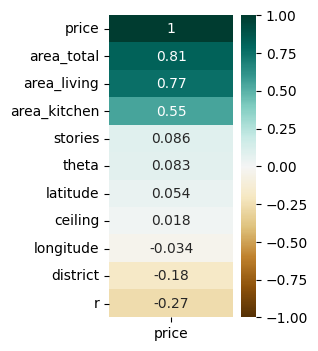

In [338]:
feats=['area_total', 'area_living', 'area_kitchen', 'stories', 'ceiling', 'r', 'theta', 'district', "longitude", "latitude"]
f, ax = plt.subplots(figsize=(2, 4), dpi=100)
heatmap = sns.heatmap(pd.merge(train_labels[feats], train_targets, left_index=True, right_index=True).corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)

### 4. APPROACH - be smarter

### DIV feature engineering and data cleaning

In [244]:
train, test, metaData = load_all_data()

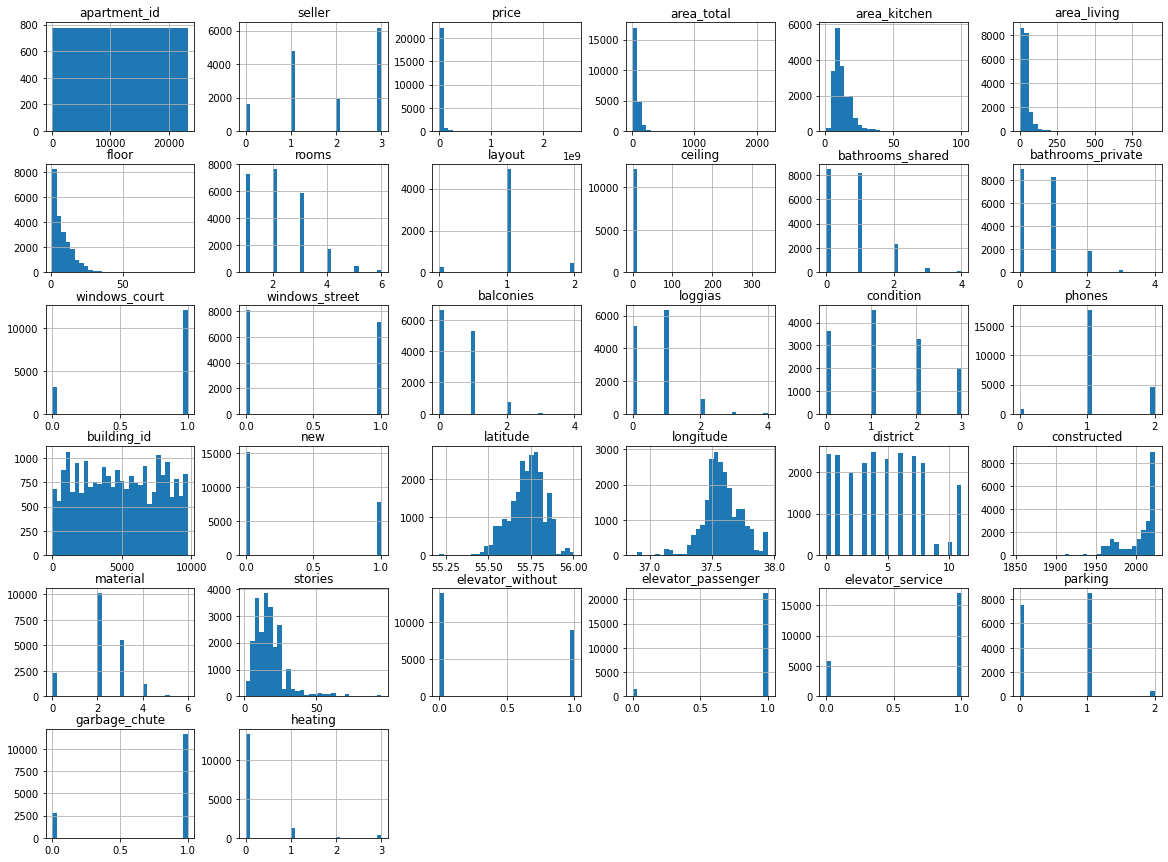

In [41]:
train.hist(bins=30, figsize=(20,15))
plt.show()

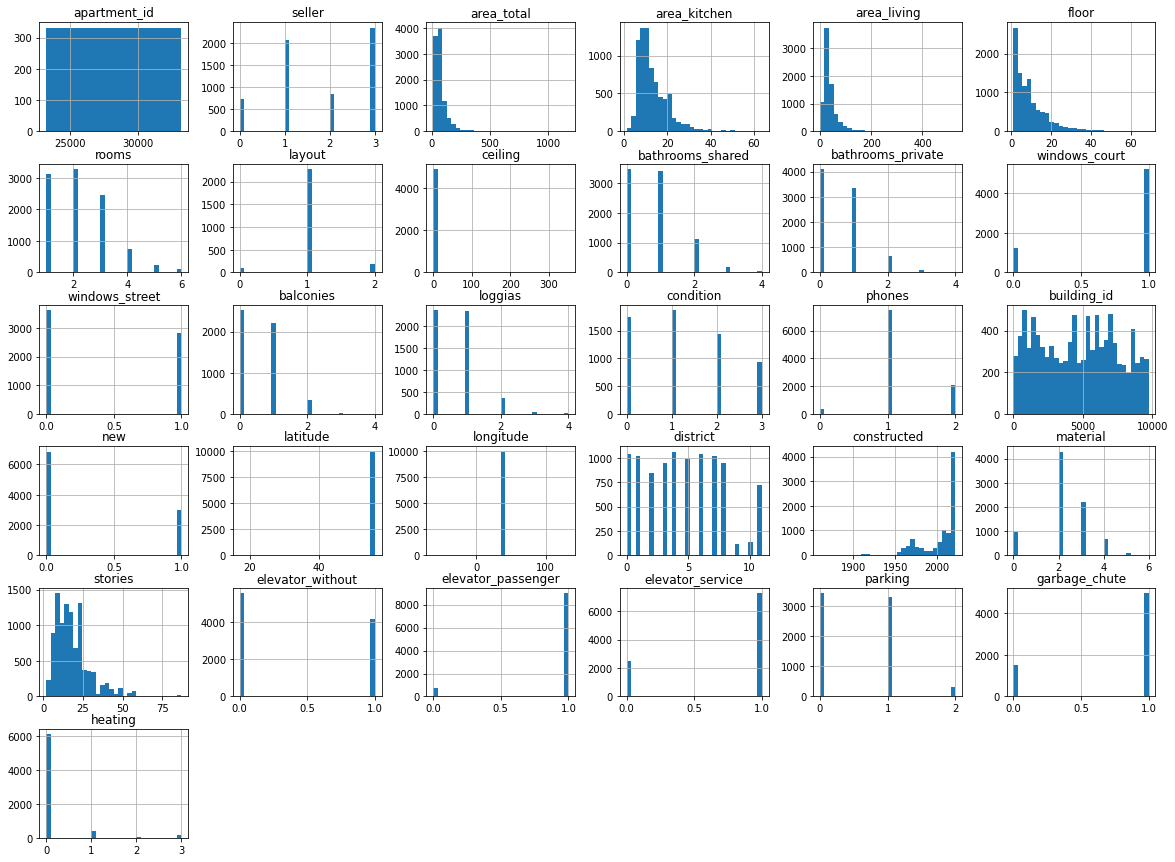

In [42]:
test.hist(bins=30, figsize=(20,15))
plt.show()

In [132]:
print(train["longitude"].min(), train["longitude"].max())
print(train["latitude"].min(), train["latitude"].max())

print(test["longitude"].min(), test["longitude"].max())
print(test["latitude"].min(), test["latitude"].max())

36.864371000000006 37.950668
55.21143000000001 56.00650699999999
-61.7905 132.76809699999998
17.141734 56.001625


Some of the test-locations are missplaced!

In [141]:
is_outlier = (test["longitude"] > 55) | (test["latitude"] < 54)
outliers =test.copy()[is_outlier]
outliers[["longitude", "latitude", "district"]]

,longitude,latitude,district
7010,-61.790500,17.141734,NaN
7011,-61.790500,17.141734,NaN
7033,74.517184,42.914700,NaN
8320,132.768097,43.353545,NaN
8518,-61.790500,17.141734,NaN
8519,-61.790500,17.141734,NaN
9867,132.759204,43.352968,NaN


In [12]:
# The problem is our training model will learn to use these values to predict. This can be solved by moving these apartments to the avg locations or smt.

In [ ]:
# Why isnt new more important?

In [258]:
train, test, metaData = load_all_data()

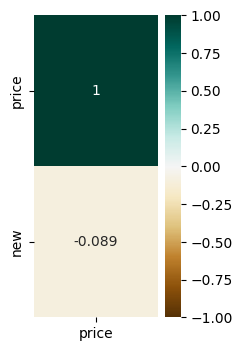

In [259]:
f, ax = plt.subplots(figsize=(2, 4), dpi=100)
heatmap = sns.heatmap(pd.merge(train["new"], train["price"], left_index=True, right_index=True).corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)

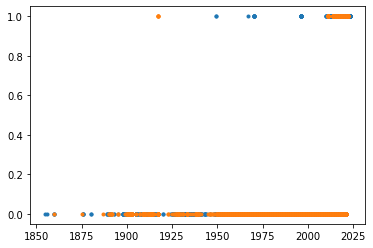

In [260]:
# Answer - a lot of outlayers in new. Only new if built in 2000 or later
plt.plot(train["constructed"], train["new"], ".")
plt.plot(test["constructed"], test["new"], ".")
plt.show()

In [261]:
is_new = [1 if row["constructed"] >= 2000 else 0 for _, row in train.iterrows()] 
train["new"] = is_new

In [262]:
is_new = [1 if row["constructed"] >= 2000 else 0 for _, row in test.iterrows()] 
test["new"] = is_new

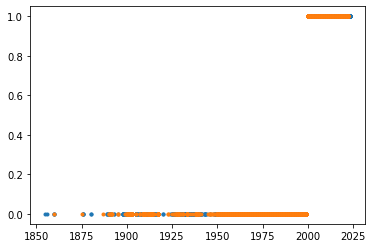

In [263]:
# Answer - a lot of outlayers in new. Only new if built in 2000 or later
plt.plot(train["constructed"], train["new"], ".")
plt.plot(test["constructed"], test["new"], ".")
plt.show()

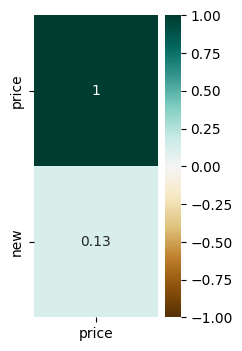

In [264]:
f, ax = plt.subplots(figsize=(2, 4), dpi=100)
heatmap = sns.heatmap(pd.merge(train["new"], train["price"], left_index=True, right_index=True).corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)

In [235]:
train, test, metaData = load_all_data()

In [243]:
train["constructed"].value_counts()


2021.0    3097
2019.0    2396
2020.0    1787
2018.0     929
2011.0     871
          ... 
1924.0       1
1856.0       1
1901.0       1
1895.0       1
1944.0       1
Name: constructed, Length: 128, dtype: int64

In [236]:
print(train["area_total"].min(), train["area_total"].mean(), train["area_total"].max())
print(test["area_total"].min(), test["area_total"].mean(), test["area_total"].max())

9.3 74.45099935580846 2181.0
13.0 75.14421857703533 1175.0


In [237]:
print(train["area_living"].min(), train["area_living"].mean(), train["area_living"].max())
print(test["area_living"].min(), test["area_living"].mean(), test["area_living"].max())

0.0 38.74136679894862 900.0
0.0 39.50051528163677 528.0


In [238]:
print(train["area_kitchen"].min(), train["area_kitchen"].mean(), train["area_kitchen"].max())
print(test["area_kitchen"].min(), test["area_kitchen"].mean(), test["area_kitchen"].max())

1.0 12.552278603749192 100.0
1.2 12.874883177570094 63.6


In [240]:
print(train["floor"].min(), train["floor"].mean(), train["floor"].max())
print(test["floor"].min(), test["floor"].mean(), test["floor"].max())

1.0 8.969594159330041 95.0
1.0 9.184160209318708 69.0


In [241]:
print(train["rooms"].min(), train["rooms"].mean(), train["rooms"].max())
print(test["rooms"].min(), test["rooms"].mean(), test["rooms"].max())

1.0 2.189349366544986 6.0
1.0 2.202878132233068 6.0


In [242]:
print(train["constructed"].min(), train["constructed"].mean(), train["constructed"].max())
print(test["constructed"].min(), test["constructed"].mean(), test["constructed"].max())

1855.0 2002.7295807211774 2023.0
1860.0 2002.2395691728536 2022.0


#### OUTLAYERS


https://www.kaggle.com/alexeyleshchenko/prediction-of-moscow-apartment-prices

# Watch out for these!

In [96]:
train, test, metaData = load_all_data()

### 1 Some straight lines

In [50]:
test[test["area_living"]>test["area_total"]].index

Int64Index([ 542,  556,  557,  621,  732,  759,  760,  761,  808,  822,  823,
             839,  882,  886,  887,  888,  899,  900,  903,  904,  905,  909,
             910,  914,  915,  939,  944,  951,  952,  953,  954,  971,  985,
             986,  994, 1007, 1016, 1143, 1196, 2437, 5475, 7059, 7062, 7070,
            7089, 7091, 7096, 7097, 7100, 7108, 8468, 8469, 9866, 9902],
           dtype='int64')

Probably corresponds to the straight lines in the living vs total plot

### 2 Ceiling height

<AxesSubplot:>

<AxesSubplot:>

340.0 350.0


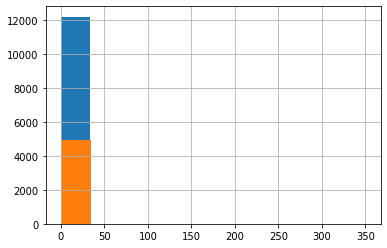

In [51]:
display(train["ceiling"].hist())
display(test["ceiling"].hist())
print(train["ceiling"].max(), test["ceiling"].max())

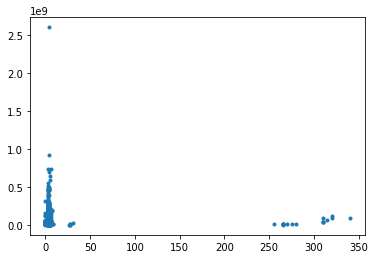

In [44]:
plt.plot(train["ceiling"], train["price"], ".")

In [97]:
print(train["ceiling"].mean())
print(test["ceiling"].mean())

3.2683735236220475
3.725885342549299


In [98]:
is_outlier = ((train["ceiling"] > 10) | (train["ceiling"] < 0.5))
outliers = train.copy()[is_outlier]
inliers_index=[]
for index in train.index:
    if index not in outliers.index:
        inliers_index.append(index)
train.loc[outliers.index,['ceiling']] = train.loc[inliers_index,['ceiling']].mean()

is_outlier = ((test["ceiling"] > 10) | (test["ceiling"] < 0.5))
outliers = test.copy()[is_outlier]
for index in test.index:
    if index not in outliers.index:
        inliers_index.append(index)
test.loc[outliers.index,['ceiling']] = test.loc[test.index.intersection(inliers_index),['ceiling']].mean()

In [99]:
print(train["ceiling"].mean())
print(test["ceiling"].mean())

2.874956967891427
2.8818913934426234


<AxesSubplot:>

<AxesSubplot:>

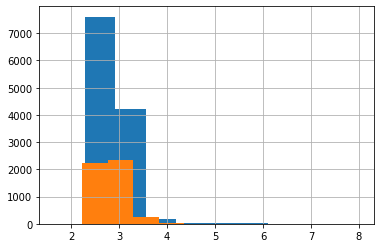

In [81]:
display(train["ceiling"].hist())
display(test["ceiling"].hist())

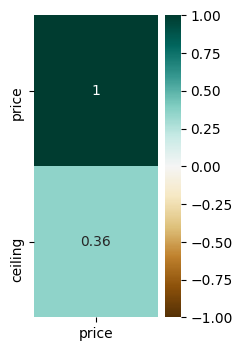

In [100]:
f, ax = plt.subplots(figsize=(2, 4), dpi=100)
heatmap = sns.heatmap(pd.merge(train["ceiling"], train["price"], left_index=True, right_index=True).corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)

### 3 -

In [101]:
train["ceiling"] = train["ceiling"].fillna(train["ceiling"].mean())
test["ceiling"] = test["ceiling"].fillna(test["ceiling"].mean())

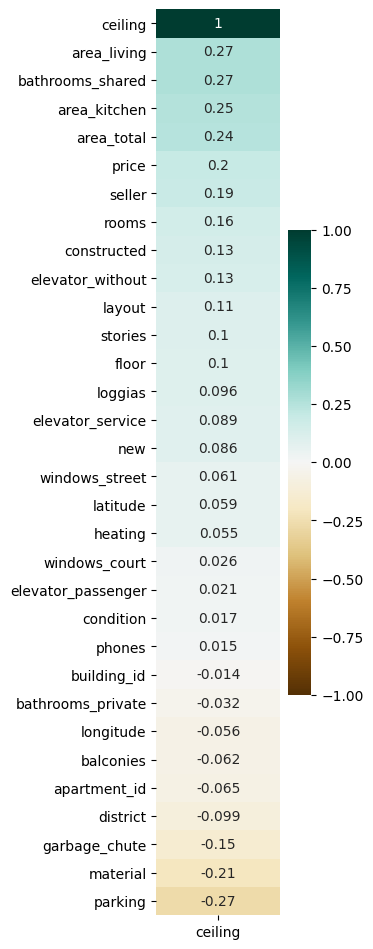

In [102]:
f, ax = plt.subplots(figsize=(2, 12), dpi=100)
heatmap = sns.heatmap(train.corr()[["ceiling"]].sort_values(by="ceiling", ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)